In [ ]:
%%capture
#!huggingface-cli login
!pip install datasets
!pip install transformers datasets
!pip install -U accelerate
!pip install -U transformers
!pip install pytorch-transformers
!pip install datasets evaluate
!pip install nltk
!pip install evaluate

In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from datasets import load_dataset
from datasets import ClassLabel
from sklearn.model_selection import train_test_split
from google.colab import drive
from tabulate import tabulate
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import random
from IPython.display import display, HTML
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import evaluate
import torch
import collections
from transformers import TrainingArguments
from transformers import Trainer
from transformers import pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ruta de los 1 archivo(datasets) en Google Drive
ruta_archivo1 = "/content/drive/MyDrive/TFM2 Coronel Joel/TFM Compartido/Books_rating.csv"

# Lee los archivos de Excel en un DataFrame de pandas
df_books = pd.read_csv(ruta_archivo1)

In [ ]:
from tabulate import tabulate

# Escoger 5 filas aleatorias de los 2 DataFrame
filas_aleatorias1 = df_books.sample(10)

# Mostrar el Dataframe comentarios de manera más bonita utilizando tabulate
print(tabulate(filas_aleatorias1, headers='keys', tablefmt='fancy_grid'))

╒═════════╤════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════╤════════════════╤══════════════════════════════════╤══════════════════════╤════════════════╤═══════════════╤════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

In [ ]:
print(df_books.shape)
print(df_books.info())

(3000000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB
None


In [ ]:
df_books = df_books[['review/score','review/text']]

In [ ]:
# Calculamos de cada columna el porcentaje de registros nulos en el dataset
# df_books.isna().sum()
for col in df_books.columns:
    pct_missing = np.mean(df_books[col].isnull())
    pct_missing1 = np.sum(df_books[col].isnull(). sum())
    conteo = sum(df_books[col].isnull())
    print('{} - {}% - {}'.format(col, round(pct_missing*100),round(pct_missing1)))

review/score - 0% - 0
review/text - 0% - 8


In [ ]:
df_books = df_books.dropna()

In [ ]:
print(df_books.shape)
df_books.isna().sum()

(2999992, 2)


review/score    0
review/text     0
dtype: int64

In [ ]:
!pip install nltk
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
# Descargar los recursos necesarios de nltk
nltk.download('stopwords')

def limpiar_texto2(texto1):
    # Convertir a minúsculas
    texto1 = texto1.lower()

    # Eliminar caracteres especiales y números usando expresiones regulares
    texto1 = re.sub(r'[^a-z\s]', '', texto1)

    return texto1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Transformamos las variables en tipo STRING

df_books['review/text'] = df_books['review/text'].astype(str)

In [ ]:
df_books.rename(columns={'review/score':'score','review/text':'text'},inplace=True)

Dividir el dataset en tres diferentes dataset el conjunto de 60% entrenamiento, 20% prueba y 20% validación

In [ ]:
from sklearn.model_selection import train_test_split

# Primero dividimos 20% en prueba y 80%  en (entrenamiento y validación)
resto , prueba_books , resto_clase , prueba_clase = train_test_split(df_books[["text"]],
                                                               df_books["score"], test_size= 0.20)

# Segundo el 80% del resto se divide en 60% entrenamiento y 20% validacion que en este caso es 25% por regla de 3
entrenamiento_books , validacion_books , entrenamiento_clase , validacion_clase = train_test_split(resto[["text"]],
                                                               resto_clase, test_size= 0.25)

In [ ]:
# Asignar un nombre a la única columna de clase
data_prueba = {'score': prueba_clase}
data_entrenamiento = {'score': entrenamiento_clase}
data_validacion = {'score': validacion_clase}

# Convertir la columna calificacion en entero
data_prueba = pd.DataFrame(data_prueba)
data_prueba['score'] =  data_prueba['score'].astype(int)
data_entrenamiento = pd.DataFrame(data_entrenamiento)
data_entrenamiento['score'] =  data_entrenamiento['score'].astype(int)
data_validacion = pd.DataFrame(data_validacion)
data_validacion['score'] =  data_validacion['score'].astype(int)

In [ ]:
validacion_books['score'] = data_validacion
prueba_books['score'] = data_prueba
entrenamiento_books['score'] = data_entrenamiento

In [ ]:
validacion_books.isna().sum()

text     0
score    0
dtype: int64

In [ ]:
prueba_books.isna().sum()

text     0
score    0
dtype: int64

In [ ]:
entrenamiento_books.isna().sum()

text     0
score    0
dtype: int64

In [ ]:
df_train = entrenamiento_books.sample(frac=0.1, replace=False, random_state=1)
df_validation = validacion_books.sample(frac=0.1, replace=False, random_state=1)
df_test = prueba_books.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
print(df_train.shape)
df_train.isna().sum()

(179999, 2)


text     0
score    0
dtype: int64

In [ ]:
print(df_validation.shape)
df_validation.isna().sum()

(60000, 2)


text     0
score    0
dtype: int64

In [ ]:
print(df_test.shape)
df_test.isna().sum()

(60000, 2)


text     0
score    0
dtype: int64

# **Codigo Para Prueba de MODELO:**

In [ ]:
df_validation_reducido = validacion_books.sample(frac=0.00167, replace=False, random_state=2)

In [ ]:
print(df_validation_reducido.shape)
df_validation_reducido.isna().sum()

(1002, 2)


text     0
score    0
dtype: int64

In [ ]:
head_val_reducido = df_train.sample(n=5)
head_val_reducido

,text,score
1031402,really liked this book was very interesting an...,5
1466506,While I generally love the &quot;In Death&quot...,2
1786118,Book is totally MISREPRESENTED (...) It is not...,1
1501582,I am a 7th grade teacher who has a wide range ...,3
552906,I am still reading this book but have so far f...,4


In [ ]:
head_aleatorio = df_train.sample(n=5)
head_aleatorio

,text,score
2055196,"I just wish there were even more, like every o...",5
1495207,"Have you read 'Dune', 'Stranger in a Strange L...",5
1285148,This is a great story and I really enjoyed all...,3
1353656,We are living during a time of copious choice....,5
816588,The Grapes of Wrath was an excellent book and ...,5


In [ ]:
# Convertir DataFrames a conjuntos de datos de Hugging Face
dataset_hf_train = Dataset.from_pandas(df_train)
dataset_hf_validation = Dataset.from_pandas(df_validation)
dataset_hf_test = Dataset.from_pandas(df_test)

In [ ]:
dataset_hf_train = dataset_hf_train.filter(lambda x : x["score"] !=3)
dataset_hf_validation = dataset_hf_validation.filter(lambda x : x["score"] !=3)
dataset_hf_test = dataset_hf_test.filter(lambda x : x["score"] !=3)

Filter:   0%|          | 0/179999 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

In [ ]:
def merge_star_ratings(examples):
    if examples["score"] <= 2:
        label = 0
    else:
        label = 1
    return {"labels": label}

In [ ]:
dataset_hf_train = dataset_hf_train.map(merge_star_ratings)
dataset_hf_validation = dataset_hf_validation.map(merge_star_ratings)
dataset_hf_test = dataset_hf_test.map(merge_star_ratings)

Map:   0%|          | 0/164794 [00:00<?, ? examples/s]

Map:   0%|          | 0/54958 [00:00<?, ? examples/s]

Map:   0%|          | 0/54877 [00:00<?, ? examples/s]

In [ ]:
import random
import pandas as pd
from datasets import ClassLabel
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    "Taken from https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb"

    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(dataset_hf_train)

,text,score,__index_level_0__,labels
0,"It is a far, far better thing that I do, than I have ever done; it is a far, far better rest that I go to than I have ever known -Sydney CartonThe passage above and the opening of the novel--It was the best of times, it was the worst of times--are among the most often quoted lines from any of Dickens' works, both because they are memorable and because somehow this is the one work of his that we all get assigned in school. I assume this one is chosen because, while it is still great, it is one of his shorter efforts.The story should be familiar, Dr. Alexander Manette is freed from his unjust imprisonment in the Bastille and is reunited with his long lost daughter, Lucie, in England. They are called as witnesses at the treason trial of Charles Darnay, a dashing young Frenchman. Darnay too is falsely accused, but he is saved, in part by his resemblance to a law clerk named Sydney Carton. Darnay and Lucie eventually marry, though not before the wastrel Carton declares his love for her and his unworthiness of her. He pledges that one day he will prove himself worthy by doing her a service. That opportunity comes when Darnay is condemned to death by a French tribunal and sentenced to the guillotine.This has been one of my favorite books since the 8th Grade. There is no more thrilling moment in literature then when Carton takes Darnay's place and bravely faces certain death. It is a moment of redemption that reminds us that great literature serves human purposes; we may never have such a moment in our own lives, but the example instructs us in how we should face such a situation if the time comes. We can ask no more of ourselves than the courage and sense of honor to do that &quot;far, far better thing.&quot;GRADE: A+",5,1453409,1
1,"""WOW"" is all I was left with after completing this book. This was a great read . I couldn't put it down, I took it EVERYWHERE I went until I finished it. The trials that Rashawn went through were a trip, almost too much to believe. All in all this book was well written some parts were slightly confusing but the author tied up all loose ends very well. The ending was great and the momentum of the book was good. This was my first book from this author but certianly will not be my last, Michelle McGriff has earned me as a reader. If you want a good book with plenty of twists and turns, this is the book for you.",5,1038745,1
2,"I was first introduced to the Lloyd Alexander Taran series when I was 11, I am now 37. I have read the series at least tweny times. When I loan my books to co-workers, I have to wait for them to purchase a copy before thier children will let me have my books back. These are simply some of the best books ever writen! They are excelent for young people as well as adults.",5,815442,1
3,"This is an absolutely beautiful volume and a classic work on the Tlingit Indians. Emmons' original text was organized and completed by the late Freddie de Laguna, herself a major figure in the anthropology of the northwest (and a super person). The volume is well illustrated with historic photographs. The production is superb, from editing to paper selection and printing, and the large format volume would be a suitable coffee-table book - even beyond its scholarly value. This is a work that belongs in any library focusing on the Indians of the northwest.",5,829967,1
4,"Father Thomas Merton was a 20th Century monk, mystic and writer whose works on mysticism and theology within the Roman Catholic tradition were both controversial and growundbreaking.In The Living Bread, Fr. Merton descibes some of the theology of the euacharist, as well as the mysticism behind it. His common theme, that the eucharist transcends the sacrafice of the Mass to a living representation of the love of God is a powerful message.Utilizing traditional apologetics and references, Fr. Merton brings the reader through such theological minefields as the metaphor versus the actuality of the sacraf

Tokenizar las reseñas

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenización de las reseñas

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer.is_fast

True

In [ ]:
text = "¡hello my name is joel alexander quinaluisa!"
tokenized_text = tokenizer.encode(text)

for token in tokenized_text:
    print(token, tokenizer.decode([token]))

101 [CLS]
1067 ¡
7592 hello
2026 my
2171 name
2003 is
8963 joel
3656 alexander
21864 qui
12032 ##nal
27020 ##uis
2050 ##a
999 !
102 [SEP]


In [ ]:
encoded_text = tokenizer(text, return_tensors="pt")
encoded_text

{'input_ids': tensor([[  101,  1067,  7592,  2026,  2171,  2003,  8963,  3656, 21864, 12032,
         27020,  2050,   999,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
def tokenize_reviews(examples):
    return tokenizer(examples["text"], padding = True, truncation=True, return_tensors="pt") # Paso un texto gigante, se pasa truncation, en true xq el tamño de este vector de token es fijo (context size)

In [ ]:
columns = dataset_hf_train.column_names
columns.remove("labels")
encoded_dataset_train = dataset_hf_train.map(tokenize_reviews, batched=True, remove_columns=columns)
encoded_dataset_train

Map:   0%|          | 0/164794 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 164794
})

In [ ]:
columns = dataset_hf_validation.column_names
columns.remove("labels")
encoded_dataset_validation = dataset_hf_validation.map(tokenize_reviews, batched=True, remove_columns=columns)
encoded_dataset_validation

Map:   0%|          | 0/54958 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 54958
})

In [ ]:
columns = dataset_hf_test.column_names
columns.remove("labels")
encoded_dataset_test = dataset_hf_test.map(tokenize_reviews, batched=True, remove_columns=columns)
encoded_dataset_test

Map:   0%|          | 0/54877 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 54877
})

In [ ]:
encoded_dataset_train[0]

{'labels': 1,
 'input_ids': [101,
  2004,
  2060,
  15814,
  2031,
  2056,
  2077,
  2033,
  1011,
  1045,
  2106,
  2025,
  2215,
  2023,
  2338,
  2000,
  2203,
  1012,
  1045,
  12246,
  5632,
  2023,
  2338,
  1998,
  2001,
  27726,
  4527,
  2004,
  1045,
  4149,
  1996,
  2338,
  2241,
  2006,
  1996,
  3104,
  2396,
  1998,
  2067,
  3104,
  19962,
  22599,
  1012,
  1996,
  3494,
  2024,
  2061,
  2200,
  2613,
  2008,
  1996,
  8068,
  14977,
  2200,
  2172,
  2055,
  2054,
  6433,
  2000,
  2068,
  1012,
  4965,
  2009,
  999,
  2017,
  2097,
  2025,
  9038,
  2009,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

Cargar el modelo preentrenado

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
outputs = model(**encoded_text)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.1837, -0.1613]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Definir las métricas de rendimiento

In [ ]:
!pip install evaluate

In [ ]:
import evaluate
accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Afinar el modelo preentrenado

In [ ]:
import torch
import collections

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import TrainingArguments

model_name = model_checkpoint.split("/")[-1]

batch_size = 16
num_train_epochs=2
num_train_samples = 20_000
train_dataset = encoded_dataset_train.shuffle(seed=42).select(range(num_train_samples))
logging_steps = len(train_dataset) // (2 * batch_size * num_train_epochs)

training_args = TrainingArguments(
    output_dir="prueba5ModeloTFM2",   #Directorio donde se guardarán los resultados del entrenamiento
    num_train_epochs=num_train_epochs,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=logging_steps,
    push_to_hub=True,
    push_to_hub_model_id=f"{model_name}-finetuned-amazon_reviews_books"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1834: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case JoelVIU/bert-base-uncased-finetuned-amazon_reviews_books).
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=encoded_dataset_validation,
    tokenizer=tokenizer
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.141200,0.135605,0.958295
2,0.077800,0.153879,0.960570


TrainOutput(global_step=2500, training_loss=0.12181890561580658, metrics={'train_runtime': 7681.9307, 'train_samples_per_second': 5.207, 'train_steps_per_second': 0.325, 'total_flos': 1.05244422144e+16, 'train_loss': 0.12181890561580658, 'epoch': 2.0})

# **Empuje hacia el Hugging Face Hub**

In [ ]:
trainer.push_to_hub(commit_message="Training complete")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

events.out.tfevents.1708882487.761f86311d8f.3454.0:   0%|          | 0.00/7.35k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/JoelVIU/bert-base-uncased-finetuned-amazon_reviews_books/commit/d0b81752f2ebf81a85c18f56d9259a5850725b5b', commit_message='Training complete', commit_description='', oid='d0b81752f2ebf81a85c18f56d9259a5850725b5b', pr_url=None, pr_revision=None, pr_num=None)

# **Descargue el modelo desde el Hub**

In [ ]:
from transformers import pipeline

model_checkpoint = "JoelVIU/bert-base-uncased-finetuned-amazon_reviews_books"
pipe = pipeline("sentiment-analysis", model=model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
pipe("I like you. I love you")

[{'label': 'LABEL_1', 'score': 0.9985694885253906}]

In [ ]:
print(type(df_validation_reducido["text"]))

# Transformar la columna 'Columna1' en una lista
lista_texto = df_validation_reducido['text'].tolist()
#lista_texto = df_validation['text'].tolist()
print(type(df_validation_reducido['text']))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
# Iterar sobre la lista de texto y mantener solo las que tienen menos de 350 palabras
lista_filtrada = []
indices_validos = []

for i, cadena in enumerate(lista_texto):
    palabras = cadena.split()  # Dividir la cadena en palabras
    if len(palabras) <= 300:
        lista_filtrada.append(cadena)
        indices_validos.append(i)

In [ ]:
print(len(lista_filtrada))

908


In [ ]:
resultado_modelo = []
# Iterar sobre los datos de a columna 1 y aplicar el modelo en cada iteración
for dato in lista_filtrada:
    resultado = pipe(dato)
    #print(f"Texto: {dato}")
    #print(f"REVIEW: {resultado[0]['label']}, Score: {resultado[0]['score']}")
    #print()
    resultado_modelo.append(resultado[0]['label'])


In [ ]:
# Utilizar expresiones regulares para extraer los números de cada cadena del resultado
lista_de_resultado = []
for cadena in resultado_modelo:
    numeros_encontrados = re.findall(r'\d+', cadena)  # Encontrar todos los números en la cadena
    if numeros_encontrados:  # Verificar si se encontraron números
        numero = int(numeros_encontrados[0])  # Tomar el primer número encontrado
        lista_de_resultado.append(numero)

In [ ]:
print(lista_de_resultado)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 

In [ ]:
# Crear una lista nueva para almacenar los elementos coincidentes
score_final = []
# Transformar la columna 'Columna2' en una lista
lista_score = df_validation_reducido['score'].tolist()

# Iterar sobre los índices coincidentes y agregar los elementos correspondientes a la lista nueva
for indice in indices_validos:
    score_final.append(lista_score[indice])

# Imprimir los elementos coincidentes
print("Elementos coincidentes:", score_final)

Elementos coincidentes: [4, 5, 5, 5, 5, 5, 5, 3, 5, 4, 5, 3, 5, 3, 5, 5, 4, 5, 4, 5, 5, 5, 3, 2, 1, 5, 5, 5, 4, 5, 1, 1, 2, 1, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 1, 5, 5, 5, 3, 5, 5, 5, 5, 5, 4, 1, 4, 5, 5, 4, 5, 3, 5, 5, 5, 5, 5, 3, 4, 5, 1, 4, 5, 5, 5, 2, 4, 4, 5, 5, 1, 4, 4, 5, 4, 3, 5, 3, 5, 4, 4, 1, 5, 3, 5, 5, 5, 1, 5, 5, 5, 5, 4, 2, 5, 5, 4, 5, 1, 5, 5, 3, 5, 1, 5, 5, 2, 5, 5, 1, 5, 4, 1, 5, 5, 4, 5, 2, 5, 5, 4, 5, 3, 5, 1, 1, 4, 4, 5, 3, 5, 5, 4, 3, 2, 5, 4, 4, 3, 2, 1, 5, 5, 5, 3, 5, 4, 5, 3, 5, 1, 1, 3, 5, 5, 5, 1, 1, 5, 2, 5, 3, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 4, 5, 5, 5, 2, 4, 3, 5, 5, 5, 3, 4, 5, 1, 5, 4, 5, 4, 5, 4, 4, 5, 1, 5, 5, 5, 5, 4, 5, 5, 1, 5, 5, 2, 5, 1, 5, 5, 4, 5, 3, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 1, 5, 3, 5, 5, 2, 5, 3, 5, 3, 5, 4, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 2, 4, 5, 5, 5, 1, 5, 5, 5, 1, 3, 2, 4, 4, 5, 5, 5, 5, 4, 5, 1, 5, 5, 5, 4, 5, 1, 1, 2, 5, 5, 4, 4, 5, 4, 5, 5, 2, 5, 4, 3, 5, 3, 5, 3, 4, 5, 5, 4, 5, 

In [ ]:
cantidad_v = len(score_final)
print(cantidad_v)

908


In [ ]:
resultado_verdadero = []
# Iterar sobre los elementos de la lista1 y comparar con la lista2
for valor1, valor2 in zip(score_final, lista_de_resultado):
  if valor1 >=4 and valor2 ==1:
    resultado_verdadero.append('correct')
  elif valor1<=2 and valor2 ==0:
    resultado_verdadero.append('correct')
  elif valor1==3:
    resultado_verdadero.append('neutral')
  else:
    resultado_verdadero.append('incorrect')

In [ ]:
# Calcular la cantidad de cada valor
cantidad_valores = len(resultado_verdadero)
cantidad_C = resultado_verdadero.count('correct')
cantidad_I = resultado_verdadero.count('incorrect')
cantidad_N = resultado_verdadero.count('neutral')
print(cantidad_valores)

# Calcular los porcentajes de cada valor
porcentaje_C = (cantidad_C / cantidad_valores) * 100
porcentaje_I = (cantidad_I / cantidad_valores) * 100
porcentaje_N = (cantidad_N / cantidad_valores) * 100

908


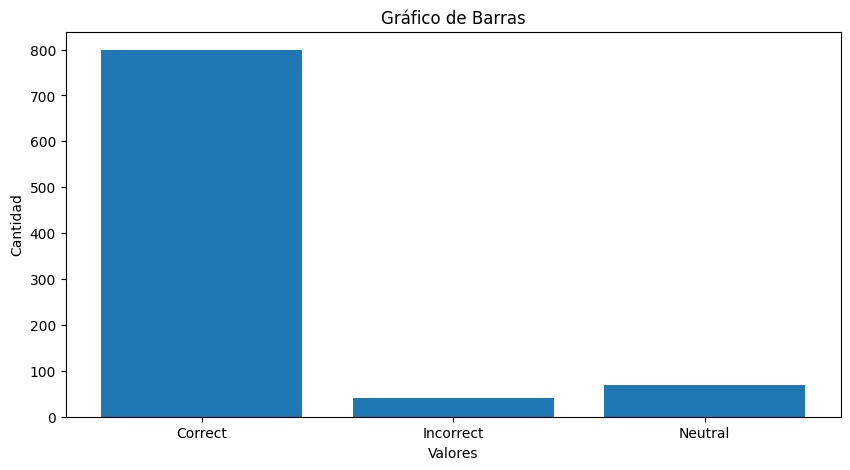

In [ ]:
import matplotlib.pyplot as plt

# Crear el gráfico de barras
plt.figure(figsize=(10, 5))
plt.bar(['Correct', 'Incorrect', 'Neutral'], [cantidad_C, cantidad_I, cantidad_N])
plt.xlabel('Valores')
plt.ylabel('Cantidad')
plt.title('Gráfico de Barras')
plt.show()

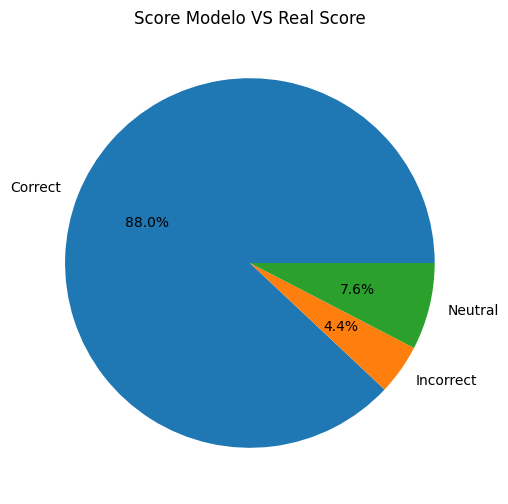

In [ ]:
# Crear el gráfico de pastel
plt.figure(figsize=(6, 6))
plt.pie([cantidad_C, cantidad_I, cantidad_N], labels=['Correct', 'Incorrect', 'Neutral'], autopct='%1.1f%%')
plt.title('Score Modelo VS Real Score')
plt.show()

In [ ]:
print("Tamaño de la lista 1:", len(score_final))
print("Tamaño de la lista 2:", len(lista_de_resultado))
print("Tamaño de la lista 3:", len(lista_filtrada))
print("Tamaño de la lista 4:", len(resultado_verdadero))

Tamaño de la lista 1: 908
Tamaño de la lista 2: 908
Tamaño de la lista 3: 908
Tamaño de la lista 4: 908


In [ ]:
df_final = pd.DataFrame({'Texto': lista_filtrada, 'Calificación_Original': score_final, 'Calificación_Modelo': lista_de_resultado, 'Resultado': resultado_verdadero})

In [ ]:
df_final.head()

,Texto,Calificación_Original,Calificación_Modelo,Resultado
0,I liked this book because it was interesting.I...,4,1,correct
1,Without a doubt the most influentialblack woma...,5,1,correct
2,I remember years ago as a child my father brin...,5,1,correct
3,A really insightful and illuminating book abou...,5,1,correct
4,Got as a gift for my niece and she loves it. W...,5,1,correct


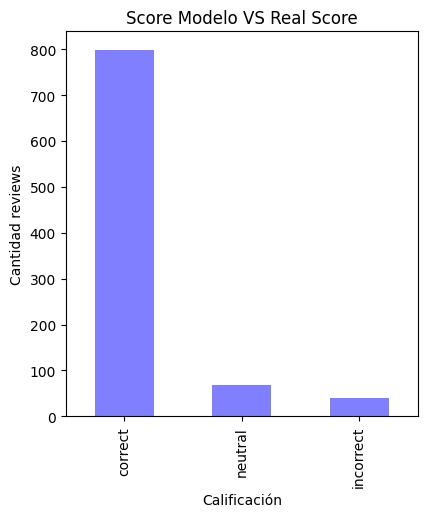

In [ ]:
# Contar las ocurrencias de cada valor en la columna
conteo_valores = df_final['Resultado'].value_counts()

# Calcular el porcentaje de cada valor
porcentaje_valores = (conteo_valores / len(df_final)) * 100

# Crear el gráfico de barras
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
conteo_valores.plot(kind='bar', color='blue', alpha=0.5)
plt.xlabel('Calificación')
plt.ylabel('Cantidad reviews')
plt.title('Score Modelo VS Real Score')
plt.show()

for i, v in enumerate(conteo_valores):
    ax1.text(i, v + 0.5, str(v), ha='center', va='bottom')


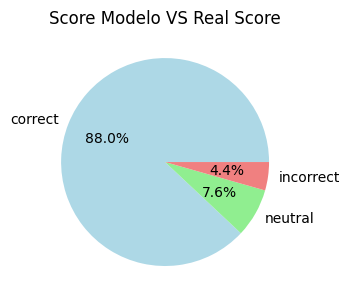

In [ ]:
# Crear el gráfico de pastel
plt.subplot(1, 2, 2)
porcentaje_valores.plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Score Modelo VS Real Score')
plt.ylabel('')

plt.tight_layout()
plt.show()